# Random Forest Model for Song Popularity Prediction

This version includes cross-validation, hyperparameter tuning, and feature importance visualization.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading and Preprocessing

In [2]:
DATA_DIR = './Data/'
TRACK_FILE = 'spotify_tracks_kaggle_weekly.csv'
ARTIST_FILE = 'spotify_tracks_artist_details.csv'

RANDOM_STATE = 21
TEST_SIZE = 0.1

In [3]:
tracks_data = pd.read_csv(DATA_DIR + TRACK_FILE)
artists_data = pd.read_csv(DATA_DIR + ARTIST_FILE)

data = pd.merge(tracks_data, artists_data, on='track_id', how='left')

le = LabelEncoder()

In [4]:
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (62317, 30)


,track_id,track_name_x,artist_name,year,popularity,artwork_url,album_name,acousticness,danceability,duration_ms,...,track_url,language,track_name_y,artist_count,artist_ids,artist_names,artist_popularities,artist_genres,artist_followers,avg_artist_popularity
0,2r0ROhr7pRN4MXDMT1fEmd,"Leo Das Entry (From ""Leo"")",Anirudh Ravichander,2024,59,https://i.scdn.co/image/ab67616d0000b273ce9c65...,"Leo Das Entry (From ""Leo"")",0.0241,0.753,97297.0,...,https://open.spotify.com/track/2r0ROhr7pRN4MXD...,Tamil,"Leo Das Entry (From ""Leo"")",1.0,4zCH9qm4R2DADamUHMCa6O,Anirudh Ravichander,85,"desi hip hop,filmi,tamil hip hop",35404621,85.000000
1,4I38e6Dg52a2o2a8i5Q5PW,AAO KILLELLE,"Anirudh Ravichander, Pravin Mani, Vaishali Sri...",2024,47,https://i.scdn.co/image/ab67616d0000b273be1b03...,AAO KILLELLE,0.0851,0.780,207369.0,...,https://open.spotify.com/track/4I38e6Dg52a2o2a...,Tamil,AAO KILLELLE,3.0,"4zCH9qm4R2DADamUHMCa6O,2ccgDZHHVlcOssv1y8AkOc,...","Anirudh Ravichander,Pravin Mani,Vaishali Sripr...","85,44,10","desi hip hop,filmi,tamil hip hop|tamil indie|","35404621,22631,65",46.333333
2,59NoiRhnom3lTeRFaBzOev,Mayakiriye Sirikiriye - Orchestral EDM,"Anirudh Ravichander, Anivee, Alvin Bruno",2024,35,https://i.scdn.co/image/ab67616d0000b27334a1dd...,Mayakiriye Sirikiriye (Orchestral EDM),0.0311,0.457,82551.0,...,https://open.spotify.com/track/59NoiRhnom3lTeR...,Tamil,Mayakiriye Sirikiriye - Orchestral EDM,3.0,"4zCH9qm4R2DADamUHMCa6O,4geIqmrfQoa4HDIF68vgiy,...","Anirudh Ravichander,Anivee,Alvin Bruno","85,40,40","desi hip hop,filmi,tamil hip hop|tamil indie|t...","35404621,3356,3461",55.000000
3,5uUqRQd385pvLxC8JX3tXn,Scene Ah Scene Ah - Experimental EDM Mix,"Anirudh Ravichander, Bharath Sankar, Kabilan, ...",2024,24,https://i.scdn.co/image/ab67616d0000b27332e623...,Scene Ah Scene Ah (Experimental EDM Mix),0.2270,0.718,115831.0,...,https://open.spotify.com/track/5uUqRQd385pvLxC...,Tamil,Scene Ah Scene Ah - Experimental EDM Mix,5.0,"4zCH9qm4R2DADamUHMCa6O,7jFE7CFeIIX7JhA8HwNH54,...","Anirudh Ravichander,Bharath Sankar,Kabilan,CM ...","85,39,61,15,29","desi hip hop,filmi,tamil hip hop|kollywood,tam...","35404621,13269,78316,8,1940",45.800000
4,1KaBRg2xgNeCljmyxBH1mo,Gundellonaa X I Am A Disco Dancer - Mashup,"Anirudh Ravichander, Benny Dayal, Leon James, ...",2024,22,https://i.scdn.co/image/ab67616d0000b2735a59b6...,Gundellonaa X I Am a Disco Dancer (Mashup),0.0153,0.689,129621.0,...,https://open.spotify.com/track/1KaBRg2xgNeCljm...,Tamil,Gundellonaa X I Am A Disco Dancer - Mashup,8.0,"4zCH9qm4R2DADamUHMCa6O,61if35zz1W11GejEkxTLEQ,...","Anirudh Ravichander,Benny Dayal,Leon James,Bap...","85,72,62,61,29,63,22,31","desi hip hop,filmi,tamil hip hop|filmi,modern ...","35404621,4539306,440298,3051448,3121,69724,304...",53.125000


### Feature Engineering and Selection

In [5]:
def get_max_popularity(x):
    if pd.isna(x):
        return None
    try:
        popularities = [int(i) for i in x.split(',')]
        return max(popularities)
    except:
        return None

data['max_artist_popularity'] = data['artist_popularities'].apply(get_max_popularity)

In [6]:
numeric_features = [
    'year', 'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness',
    'tempo', 'time_signature', 'valence', 'artist_count', 'avg_artist_popularity',
    'max_artist_popularity'
]

categorical_features = ['album_name', 'language']

for feature in categorical_features:
    data[feature + '_encoded'] = le.fit_transform(data[feature].astype(str))

features = numeric_features + [f + '_encoded' for f in categorical_features]

X = data[features]
y = data['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

### Cross-Validation Analysis

In [7]:
base_model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    base_model,
    X, y, 
    cv=5,
    scoring='neg_mean_squared_error'
)

rmse_scores = np.sqrt(-cv_scores)
print(f'Cross-validation RMSE scores: {rmse_scores}')
print(f'Mean RMSE: {rmse_scores.mean():.2f} (+/- {rmse_scores.std() * 2:.2f})')

Cross-validation RMSE scores: [19.22104495 18.55278251 18.88989444 16.24554368 13.72362806]
Mean RMSE: 17.33 (+/- 4.17)


### Hyperparameter Tuning

In [13]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 15, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("\nBest parameters:", rf_grid.best_params_)
print("Best RMSE:", np.sqrt(-rf_grid.best_score_))


Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE: 12.251432577531029


### Final Model Training and Evaluation

In [14]:
best_rf = rf_grid.best_estimator_
y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nFinal Model Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
print(f"R² Score: {r2:.2f}")


Final Model Performance:
Mean Squared Error: 155.60
Root Mean Squared Error: 12.47
R² Score: 0.56


### Feature Importance Analysis

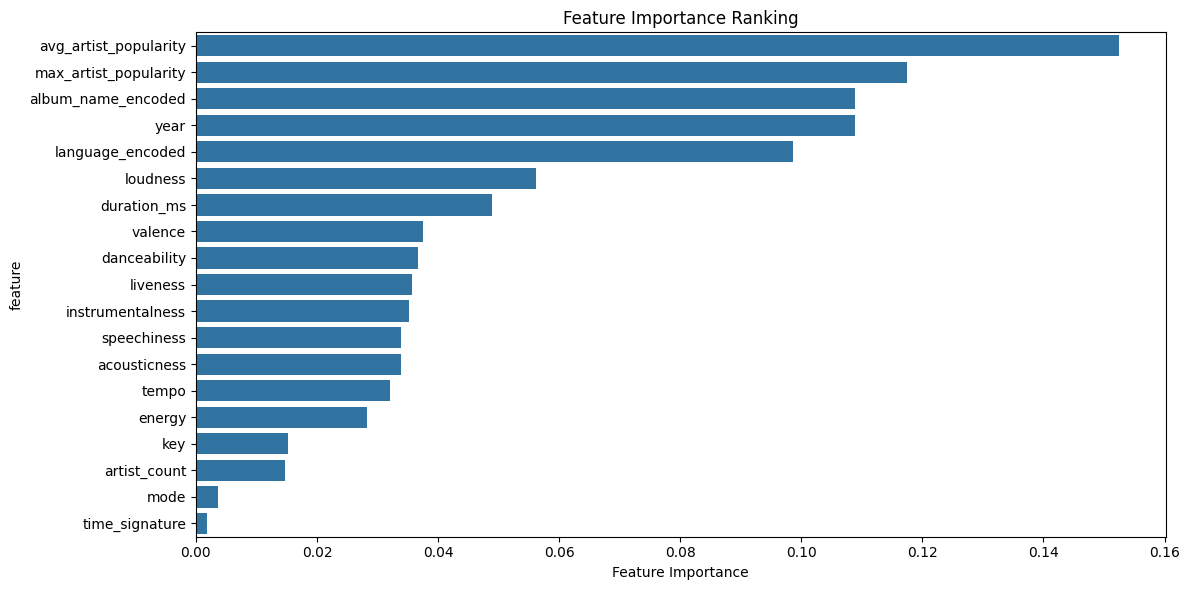

In [15]:
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance Ranking')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

### Model Performance Visualization

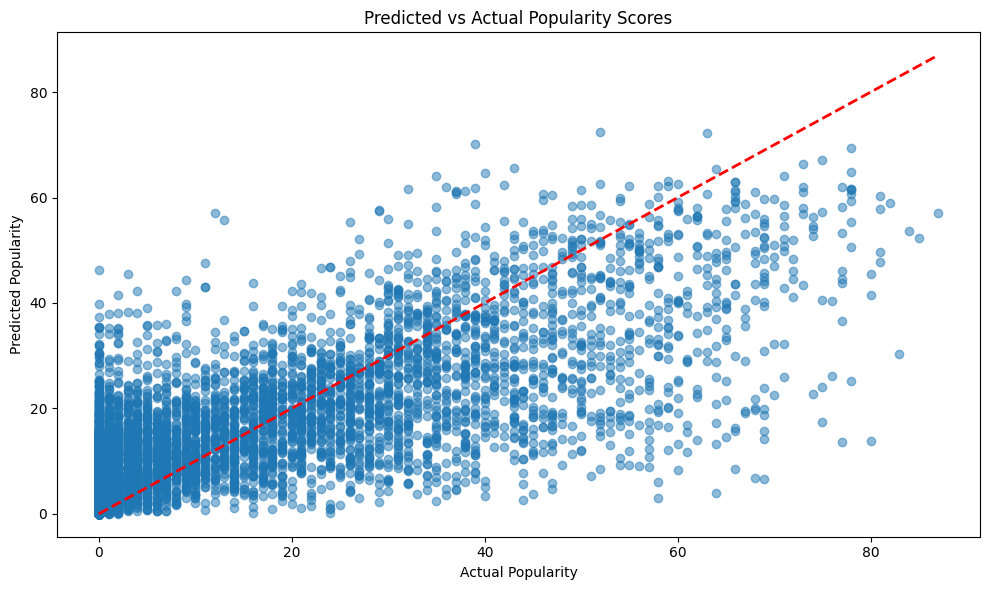

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Predicted vs Actual Popularity Scores')
plt.tight_layout()
plt.show()